
## OR Study Group: Queueing Theory

### Collaborators: 
* Clare Essex
* Hamish MacGregor
* Rudi Narendran
* Jonathan Teagles
* Emma Tearse

This notebook is designed to run simple queueing theory models using python via mybinder.org



The notebook is structured in XX parts:
* [Set Up](#setup)
* [Theory](#theory1)
* [Simple Queues - M/M/1](#simple)
    * [Case Study 1: XX](#casestudy1)
* [Understanding $\lambda$, $\alpha$ and other variables](#theory2)
* [Complex Queues - M/M/$\infty$](#complex)
    * [Case Study 2: XX](#casestudy2)

## Set Up <a class = "anchor" id = "setup"></a>

We need to install some packages to run this notebook:
* **pandas** - this is a package for *shaping* data
* **numpy** - this is a package with helpful functions for *numerical transformations*
* **matplotlib** - this is a package for *visualisiations*

There are installed using the command **pip install 'package'** and then *imported* into your notebook using **import 'package'**, we can give the package a shortened name as we will need to call it a lot later.

*Note: pip should be run from the command line, to run a shell command from within a notebook cell, you must put a ! in from of the command*

So let's do this for the above packages:

In [1]:
!pip install pandas
import pandas as pd

In [2]:
!pip  install numpy
import numpy as np

In [3]:
!pip install matplotlib
import matplotlib.pyplot as plt

In [4]:
!pip install ciw
import ciw

## Simple Queue Simulation - M/M/1  <a class = "anchor" id = "simple"></a>

Here we will use the *ciw* package to build a simple M/M/1 queue, such as a queue at a supermarket checkout. The system has a single server, with a single queue.

First, we create the _network_ '_N_', which defines the structure of the queueing system.
Functions preceded by _ciw._ are built into the *ciw* package.

In [5]:
#Set up mean arrival rate and service rate (see below)
arrival_rate = 0.2
service_rate = 0.25

ciw.seed(1) # defines a random seed, ensuring the results are the same on each run

N = ciw.create_network(
    arrival_distributions = [ciw.dists.Exponential(arrival_rate)],
    service_distributions = [ciw.dists.Exponential(service_rate)],
    number_of_servers = [1])

This network has three attributes:
* The **arrival distribution**, which we have set to be exponential (Poisson process) with a mean arrival rate $\lambda$ of 0.2 customers per minute (1 every 5 minutes)
* The **service distribution**, which we have also set to be exponential with a mean arrival rate $\mu$ of 0.25 customers per minute (1 every 4 minutes). Since $\lambda < \mu$, the queue should be stable and not grow indefinitely.
* The **number of servers**, which in this case is 1.

Note that the choice of units (minutes) is arbitrary and will work as long as we are consistent.

We can now simulate the queue by creating and running a *Simulation* object, *Q*:

In [6]:
Q = ciw.Simulation(N) # a Simulation object for our network N

Q.simulate_until_max_time(1440) # run the simulation Q for 1440 minutes (one day)

The *ciw* package automatically records useful statistics about the simulation. For instance, we can obtain the average time spent waiting in the queue, or the average time to be served:

In [7]:
recs = Q.get_all_records() # extracts all individual records into the list 'recs'

wait_times = [r.waiting_time for r in recs] # loops through 'recs' extracting waiting times
service_times = [r.service_time for r in recs] # likewise for service times

We can now easily extract the mean waiting time and service time using np.mean():

In [8]:
#mean service time
np.mean(service_times)

3.9426083677557755

In [9]:
#mean waiting time
np.mean(wait_times)

7.467608756778196

We set up the simulation with $\mu = 0.25$, so we are expecting a mean service time ($1/\mu$) of 4 minutes - our result of 3.94 minutes is not far off. For the waiting time, we can use the formula

$T = \frac{\mu}{1-\lambda/\mu} - \frac{1}{\mu}$

In [10]:
T = (1/service_rate)/(1-arrival_rate/service_rate) - 1/service_rate
T

16.000000000000004

Our estimate of 7.47 minutes is not so close here. This is because we are doing just one simulation - to get accurate results, we should run the simulation multiple times and average the results. Try setting a different seed and running it again!

In [11]:
# This block is for study group team only - what happens when you run multiple times with different seeds. 
# the results are an underestimate due to the transient behaviour at the start, but this is dealt with later.
# we probably won't actually average their results during the presentation, just ask them to post in the chat. 

wait_array = np.array([])
for trial in range(200):
    ciw.seed(trial)
    Q = ciw.Simulation(N)
    Q.simulate_until_max_time(1440)
    recs = Q.get_all_records()
    wait_times = [r.waiting_time for r in recs]
    service_times = [r.service_time for r in recs]
    wait_array = np.append(wait_array, np.mean(wait_times))
    
np.mean(wait_array)

13.839668659971318

### Plotting the queue behaviour

Let's explore the M/M/1 queue a little further. We can track the state of the system using a 'tracker'. Let's run the same queue three times with different random seeds, and look at the queue length over time.

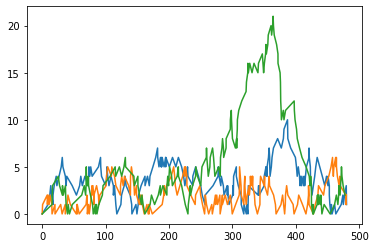

In [12]:
for trial in range(3):
    ciw.seed(trial) #set a different seed for each run
    
    #set up and run a new simulation using the same network, with a tracker on the service node
    Q2 = ciw.Simulation(N, tracker = ciw.trackers.NodePopulationSubset([0])) 
    Q2.simulate_until_max_time(480) #simulate for 8 hours
    
    #Extract the results (queue length over time) into an array
    h = np.array(Q2.statetracker.history, dtype = object)
    h[:, 1] = [i[0] for i in h[:, 1]] 
    plt.plot(h[:, 0], h[:, 1])

Try changing the mean arrival rate (at the top of this section) and see how the queue behaviour changes over time  (You will need to re-run any code blocks you change, in order top-to-bottom). What happens if you set the arrival rate higher than the service rate? What if they are equal?

We can compare our results to what we expect from the theory. Let's try varying the arrival rate, and measuring the average queue length.
We can't take the time-average queue length when the arrival rate exceeds the service rate (since the queue length diverges to infinity over time), so we will keep our arrival rates below the service rate.

First we set up our simulation parameters, and empty arrays to store the results:

In [13]:
# set parameters
test_rates = np.linspace(0.05, 0.245, 30) # we will test a range of arrival rates from 0.05 to 0.245
service_rate = 0.25
simulation_time = 1440

#create arrays for results
queue_means = np.array([])
queue_var = np.array([])
ciw.seed(3)

We can now run the simulations:

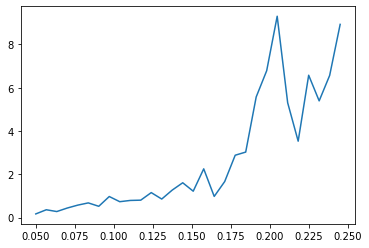

In [14]:
for arrival_mean in test_rates:
    N = ciw.create_network(
        arrival_distributions = [ciw.dists.Exponential(arrival_mean)],
        service_distributions = [ciw.dists.Exponential(service_rate)],
        number_of_servers = [1])
    
    Q = ciw.Simulation(N, tracker = ciw.trackers.NodePopulationSubset([0]))
    Q.simulate_until_max_time(simulation_time)
    probs = Q.statetracker.state_probabilities() # a discrete probability distribution for the queue length
    probs = np.array(list(probs.items()), dtype = object) # convert dictionary object to array
    probs[:, 0] = [i[0] for i in probs[:, 0]]
    
    queue_mean = sum(probs[:, 0] * probs[:, 1]) # calculate mean queue length
    queue_means = np.append(queue_means, queue_mean)
    queue_var = np.append(queue_var,
        sum(probs[:, 0] * probs[:, 0] * probs[:, 1]) - queue_mean) # calculate queue length variance
    
plt.plot(test_rates, queue_means)

We can see that the average queue length increases rapidly as we approach equal arrival and service rates.

The theory predicts that the mean queue length $L$ is determined by the following expressions:

$L =  \frac{\lambda/\mu}{1-\lambda/\mu}$

We can compare this to our trials:

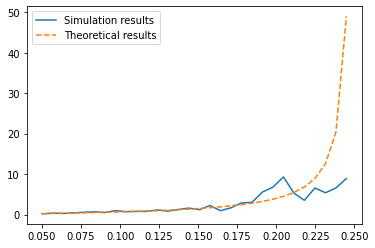

In [15]:
pred_length = (test_rates/service_rate)/(1 - test_rates/service_rate) #calculate theoretical results

#plot and compare
plt.plot(test_rates, queue_means, label = "Simulation results")
plt.plot(test_rates, pred_length, '--', label = "Theoretical results")
plt.legend()

Something is not quite right here! The results are OK at low $\lambda$, but as we increase the arrival rate, the simulation results become noisy and we appear to be underestimating the rise in average queue length. What have we done wrong?

Answer below...

.

.

.

.

.

.

.

.

**We have run the simulation for too short a time.** This is producing two effects:
* *The simulation becomes noisy as the arrival rate approaches the service rate* - the theory predicts that the size of the fluctuations in the  queue length increases as $\lambda$ approaches $\mu$. In order to get accurate results, we must simulate for a long time.
* *The queue has not reached a steady state* - as $\lambda$ increases and the queue becomes longer, we must wait longer before the queue reaches a steady state. Near the start, the queue is shorter than average (since we started with an empty queue), so our mean queue length is too low. For a truly accurate result, we ought to exclude the start from our measurements, but we can improve things by running the simulation for longer.

Try running the simulation again for a longer time, and see if the results improve!

## Cafe Game <a class = "anchor" id = "casestudy2"></a>

This simple game demonstrates the more advanced functionality of the *ciw* package. 

You are the manager of a city-centre take-away cafe (remember those?). There is a **single queue** for **up to five tills**, and you must set the schedule for staffing the tills through the day. If the queues get too long, customers will give up, but more staff will cost more money! Your aim is to make as much profit as you can (sales minus staff costs) in a single day.

Run the code below to see the arrival rate for customers through the day

(6.0, 21.0)

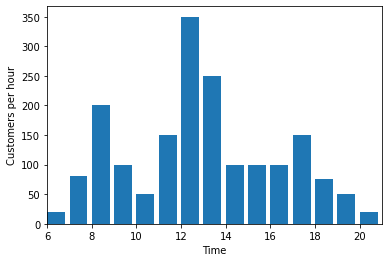

In [16]:
# Customer arrival rate
arrivals = [0, 0, 0, 0, 0, 0, 20, 80, 200, 100, 50, 150, 350, 250, 100, 100, 100, 150, 75, 50, 20, 0, 0, 0]
plt.bar(x = range(24),height = arrivals, align = 'edge')
plt.xlabel("Time")
plt.ylabel("Customers per hour")
plt.xlim(6, 21)

Now set the staff schedule. **Change the numbers in the first column** below to determine how many staff work each 2-hour shift (default is 1 for each shift, the second column represents time, in hours)

The staff serve customers at an average of **one customer per minute**. You may not have more than **eight** staff on any shift.

You earn £3 for each customer served, and you must pay the staff £50/hr

In [17]:
sched = [[0, 6], #up to 6am (no staff, as there are no customers)
        [1, 8],  #6-8am
        [1, 10],  #8-10am
        [1, 12],  #10am-12pm
        [1, 14],  #12-2pm
        [1, 16],  #2-4pm
        [1, 18],  #4-6pm
        [1, 20],  #6-8pm
        [1, 22],  #8-10pm
        [0, 24]]  #after 10pm (no staff)


You served 815 customers, but 974 customers left in frustration.
You earned GBP 2445.0 and spent GPB 800 on staff.
Your total profit was GBP 1645.0


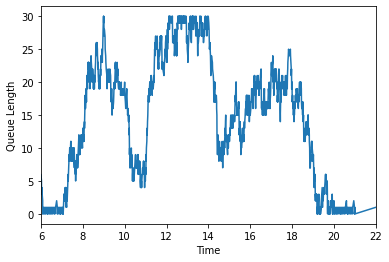

In [18]:
#Now run this code block and see your results below!
#(don't worry too much about the details of this code unless you want to)

# set up the time-dependent arrival distribution
class TimeDependentDist(ciw.dists.Distribution):
    def sample(self, t, ind = None):
        t_round = int(np.floor(t))
        if arrivals[t_round] == 0:
            return 1 # the system must have at least 1 customer arrive per hour - unavoidable in this case
        return 1/arrivals[t_round]
    
#set seed
ciw.seed(1)

# customers are more likely to leave ('baulk') if queues are long
def p_baulk(n):
    if n<10:
        return 0.0
    if n<20:
        return 0.35
    if n<30:
        return 0.7
    return 1.0
        

#set up the network
N_cafe = ciw.create_network(
    arrival_distributions = [TimeDependentDist()],
    service_distributions = [ciw.dists.Exponential(60)], # 60 customers per hour per server
    baulking_functions = [p_baulk],
    number_of_servers = [sched])

Q_cafe = ciw.Simulation(N_cafe, tracker = ciw.trackers.NodePopulationSubset([0]))
Q_cafe.simulate_until_max_time(24)

staff_wage = 50
staff_manhrs = sum([i[0] for i in sched])*2 #(2 hour shifts)
staff_costs = staff_manhrs*staff_wage

revenue_per_customer = 3.00
custs_served = len(Q_cafe.nodes[-1].all_individuals)-9 # subtract the nine dummy customers out-of-hours
custs_baulked = len(Q_cafe.baulked_dict[1][0])
revenue = revenue_per_customer*custs_served
profit = revenue - staff_costs

print("You served", custs_served, "customers, but", custs_baulked, "customers left in frustration.")
print("You earned GBP", revenue, "and spent GPB", staff_costs, "on staff.")
print("Your total profit was GBP", profit)

h = np.array(Q_cafe.statetracker.history, dtype = object)
h[:, 1] = [i[0] for i in h[:, 1]] 
plt.plot(h[:, 0], h[:, 1])
plt.xlabel("Time");
plt.ylabel("Queue Length");
plt.xlim(6, 22);

Can you do better?